# Variational Autoencoder

## Setup

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive/')

# Add folder to load python modules
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'

import sys, os
sys.path.append(os.path.join(ROOT_PATH, 'bayesian_methods/notebooks'))
sys.path.append(os.path.join(ROOT_PATH, 'bayesian_methods/notebooks/modules'))

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import tensorflow as tf
print("TensorFlow Version: " + str(tf.__version__))

import numpy as np
import time

from variational_autoencoder import VAE, Encoder, Decoder, Plotter
from loss_function import compute_loss
from data_loader import get_mnist, get_vortex_data

TensorFlow Version: 2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
###### Choose 'True' to import and use Tensorboard ######
IMPORT_TENSORBOARD = False

if IMPORT_TENSORBOARD:
  %load_ext tensorboard
  !rm -rf ./logs/
  import tensorboard
  tensorboard.__version__
  from datetime import datetime

  current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
  train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
  test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
  train_summary_writer = tf.summary.create_file_writer(train_log_dir)
  test_summary_writer = tf.summary.create_file_writer(test_log_dir)

### Training Configuration

In [4]:
###### Set training configuration ######
epochs = 25
lr = 0.001
loss_fn = compute_loss

###### Choose dataset ######
names = ['mnist', 'fashion_mnist', 'vortex']

dataset = names[1]

if dataset=='vortex':
  batch_size = 12
  latent_dim = 3
elif dataset=='fashion_mnist' or dataset=='mnist':
  batch_size = 32
  latent_dim = 2
else:
  print("Error: Dataset selection.")

print("++++ SETUP ++++:")
print()
print("Dataset: {}".format(dataset))
print("Batch size: {}".format(batch_size))
print("Dimension latent space: {}".format(latent_dim))

++++ SETUP ++++:

Dataset: fashion_mnist
Batch size: 32
Dimension latent space: 2


## Load Data

In [5]:
###### Load datasets and set sizes & shapes ######
if dataset=='vortex':
  train_ds, test_ds, train_shape, test_shape = get_vortex_data(os.path.join(ROOT_PATH, 'data/U.h5'), batch_size=batch_size)
  train_size = train_shape[0]
  test_size = test_shape[0]
  img_shape = (train_shape[1], train_shape[2], train_shape[3])

if dataset=='fashion_mnist' or dataset=='mnist':
  (x_train, y_train), (x_test, y_test) = get_mnist(batch_size=batch_size, asarray=True, dataset=dataset)
  train_ds, test_ds, train_shape, test_shape = get_mnist(batch_size=batch_size, asarray=False, dataset=dataset)

  img_shape = (train_shape[1], train_shape[2], train_shape[3])

  (digit_size, digit_size, num_channels) = img_shape
  train_size = train_shape[0]
  test_size = test_shape[0]

print()
print("Train Size: {}".format(train_size))
print("Test Size: {}".format(test_size))
print("Image shape: {}".format(img_shape))


4423680/4422102 [==============================] - 0s 0us/step
Load Fashion MNIST
Return as Arrays

Load Fashion MNIST
Return as Datasets

Train Size: 60000
Test Size: 10000
Image shape: (28, 28, 1)


# Convolutional VAE


In [6]:
###### Initialize encoder, decoder, VAE ######
encoder_conv = Encoder(inp_shape=img_shape, latent_dim=latent_dim, net='conv')
decoder_conv = Decoder(outp_shape=img_shape, latent_dim=latent_dim, net='conv')

vae_conv = VAE(encoder_conv, decoder_conv, loss_fn)


++++ VARIATIONAL AUTOENCODER ++++

conv-Encoder
 - Input Shape: (28, 28, 1)
 - Latent Variable Space: 2

conv-Decoder
 - Latent Variable Space: 2
 - Output Shape: (28, 28, 1)

Initialize Metrics:
 - train_loss
 - train_accuracy
 - test_loss
 - test_accuracy


Progress:
Epoch 25/25, Loss: 186.12, Accuracy: 100.00, Test Loss: 188.87, Test Accuracy: 100.00, Time: 4.72 s


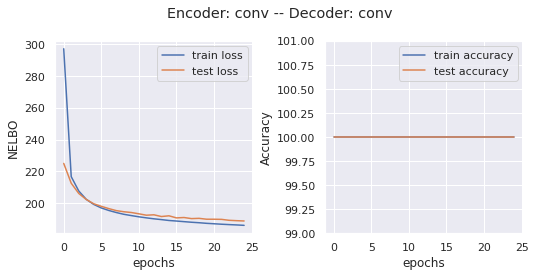

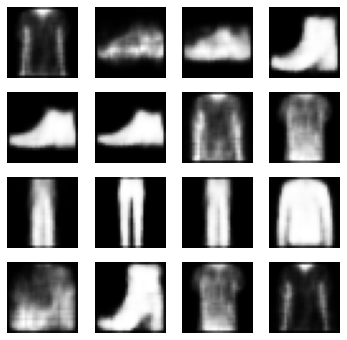


Reset Metrics


In [7]:
if IMPORT_TENSORBOARD:
  vae_conv.train_summary_writer = train_summary_writer
  vae_conv.test_summary_writer = test_summary_writer

###### Training ######
vae_conv.fit(train_ds, test_ds, epochs=epochs, save=False)

# Multilayer Perceptron VAE

In [8]:
###### Initialize encoder, decoder, VAE ######
encoder_mlp = Encoder(inp_shape=img_shape, latent_dim=latent_dim, net='mlp')
decoder_mlp = Decoder(outp_shape=img_shape, latent_dim=latent_dim, net='mlp')

vae_mlp = VAE(encoder_mlp, decoder_mlp, loss_fn)


++++ VARIATIONAL AUTOENCODER ++++

mlp-Encoder
 - Input Shape: (28, 28, 1)
 - Latent Variable Space: 2

mlp-Decoder
 - Latent Variable Space: 2
 - Output Shape: (28, 28, 1)

Initialize Metrics:
 - train_loss
 - train_accuracy
 - test_loss
 - test_accuracy


Progress:
Epoch 25/25, Loss: 185.59, Accuracy: 100.00, Test Loss: 187.98, Test Accuracy: 100.00, Time: 3.00 s


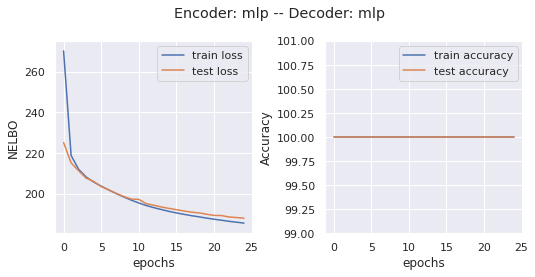

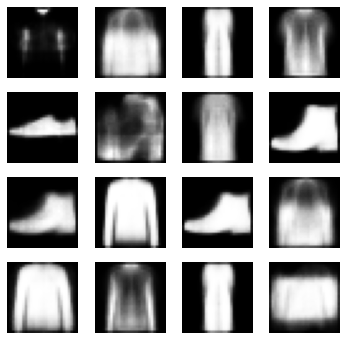


Reset Metrics


In [9]:
###### Training ######
vae_mlp.fit(train_ds, test_ds, epochs=epochs, save=False)

In [10]:
###### If selected, show Tensorboard ######
if IMPORT_TENSORBOARD: 
  %tensorboard --logdir logs/gradient_tape

# Results

## Sampling New Data
### Convolutional VAE

In [11]:
###### Used in debugging phase ######
#from importlib import reload
#import variational_autoencoder
#reload(variational_autoencoder)
#from variational_autoencoder import Plotter

In [12]:
n_samples = 20

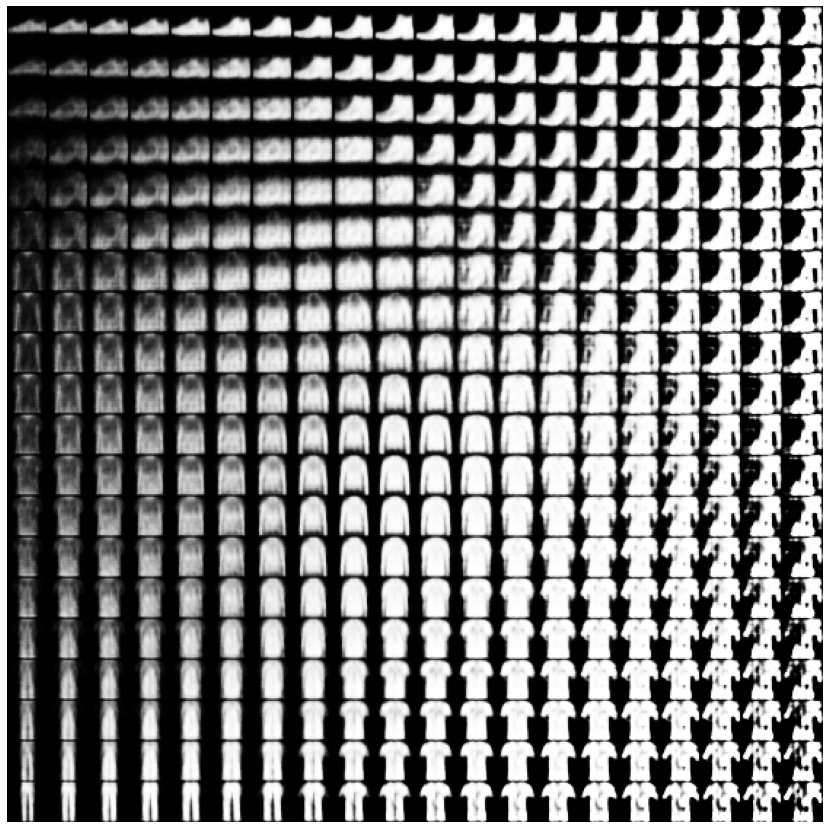

In [13]:
###### Plot samples drawn from grid in 2-dim probability space ######
plotter_conv = Plotter(vae_conv)

if latent_dim == 2:
  plotter_conv.latent_space_grid(n_samples=n_samples, img_shape=img_shape)

### Multilayer Perceptron VAE


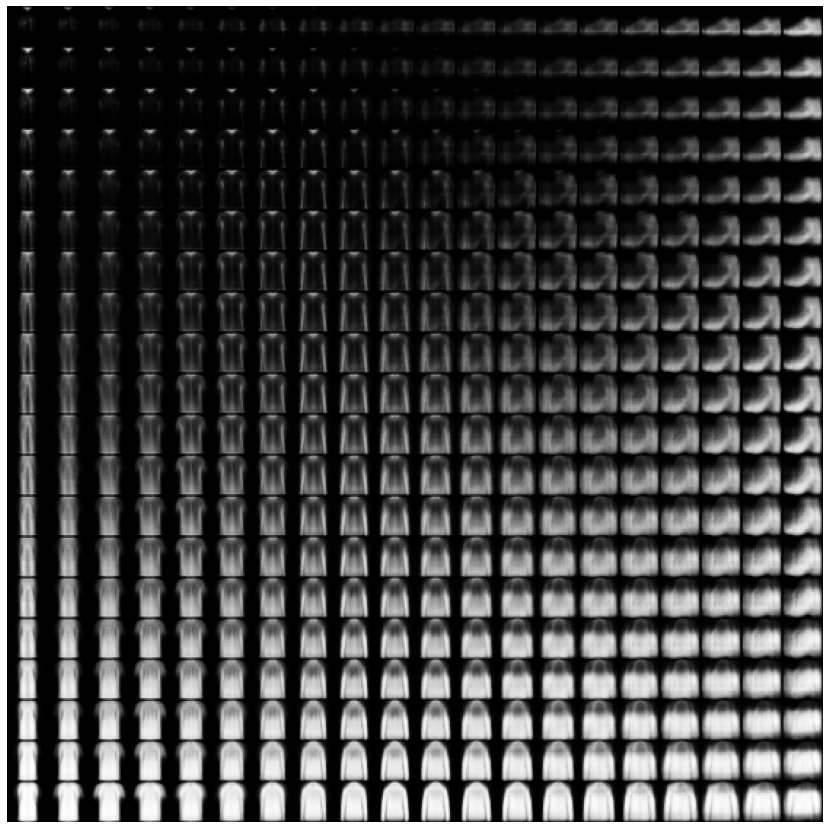

In [14]:
plotter_mlp = Plotter(vae_mlp)

if latent_dim==2:
  plotter_mlp.latent_space_grid(n_samples=n_samples, img_shape=img_shape)

### Latent Space Embedding

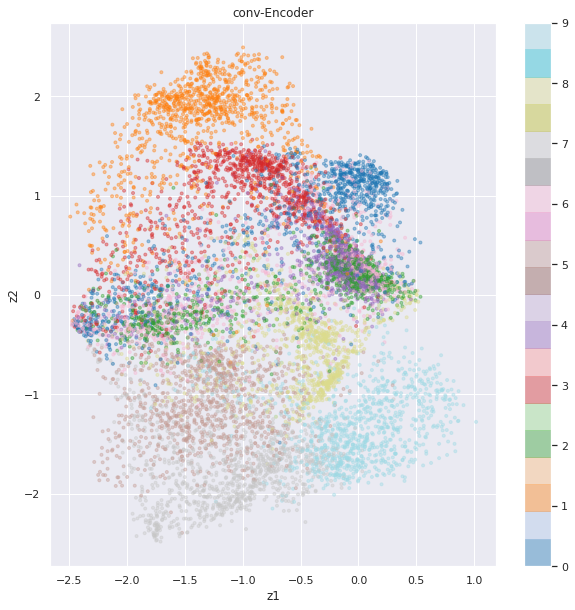

In [15]:
plotter_conv.plot_embedding(x_test, y_test)

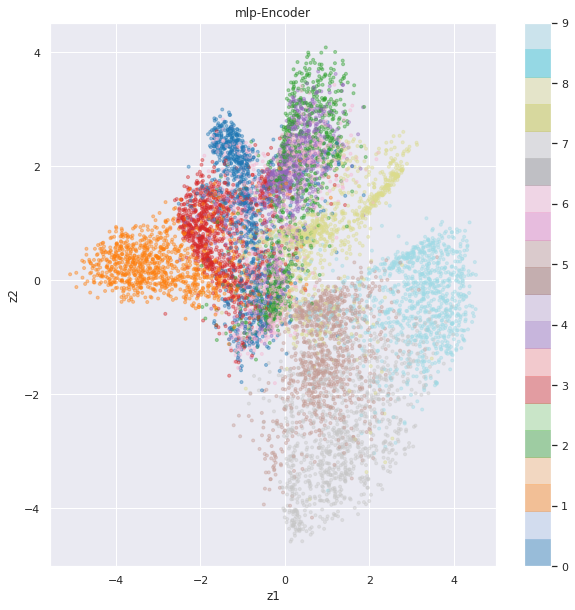

In [16]:
plotter_mlp.plot_embedding(x_test, y_test)